In [12]:
import warnings, os
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.metrics import auc as calculate_auc

import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap, AggMapNet, loadmap


from sklearn import linear_model
from sklearn.metrics import accuracy_score, roc_auc_score,roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

sns.set(style='white',  font='sans-serif', font_scale=2)  


import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import FormatStrFormatter
#gfc = gfc.rename(columns = {'AUS':"AUS", 'CHI':'CHN', 'FRA':'FRA', 'GER':'DEU', 'USA':'USA'})

sns.set(style='white',  font='sans-serif', font_scale=2)  


def tune_RF_params(X_train, y_train, random_state):
    n_estimators = [5, 20, 50, 100,200, 300] # number of trees in the random forest
    max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
    min_samples_split = [2, 6, 10] # minimum sample number to split a node
    min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
    max_features = ['auto', 'sqrt'] # number of features in consideration at every split
    bootstrap = [True, False] # method used to sample data points

    random_grid = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'max_features':max_features,
                   'bootstrap':bootstrap,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}

    rf = RandomForestClassifier(random_state=random_state)
    rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid, random_state=random_state, 
                   n_iter = 100, cv = 10, verbose=0, n_jobs = -1)
    rf_random.fit(X_train, y_train)
    best_params = rf_random.best_params_
    return best_params


def prc_auc_score(y_true, y_score):
    precision, recall, threshold  = precision_recall_curve(y_true, y_score) #PRC_AUC
    auc = calculate_auc(recall, precision)
    return auc

def get_non_diag_mean(df):
    v = df.values.copy()
    np.fill_diagonal(v, np.nan)
    mean =  pd.DataFrame(v, columns = df.columns, index = df.index).mean(axis=1).round(2)
    std = pd.DataFrame(v, columns = df.columns, index = df.index).std(axis=1).round(2)
    return mean.mean()

In [13]:
dfx = pd.read_excel('../CRC.xlsx', sheet_name='data')
dfy = pd.read_excel('../CRC.xlsx', sheet_name='sample_info')
df_imp = pd.read_excel('../results/feature_importance.xlsx', index_col=0)
mp = loadmap('../model/aggmap.mp')


dfx = dfx[dfx.columns[1:]]
dfx = np.log(dfx + 1e-8)
dfy['Country'] = dfy.Country.map({'AUS':"AUS", 'CHI':'CHN', 'FRA':'FRA', 'GER':'DEU', 'USA':'USA'})

X_3D = mp.batch_transform(dfx.values, scale_method= 'standard')
X_rf = mp.transform_mpX_to_df(X_3D)

100%|#####################################################################################################################################| 575/575 [00:04<00:00, 139.34it/s]


In [14]:
y = pd.get_dummies(dfy['Group'])
Y = y.CRC.values

In [15]:
country_idx = dfy.groupby(['Country']).apply(lambda x:x.index.tolist())
country_names = country_idx.index.tolist()

In [16]:
#study to study transfer

all_df = []
imps = []
top = 849

X = X_rf[mp.flist].values

run_all = []
for train_country in country_names:

    train_idx = country_idx.loc[train_country]
    trainX = X[train_idx]
    trainY = Y[train_idx]
    
    random_state = 123
    
    best_params = tune_RF_params(trainX, trainY, random_state = random_state)
    print(best_params)
 
    clf = RandomForestClassifier(**best_params, random_state = random_state)

    clf.fit(trainX, trainY)
    for test_country in country_names:
        test_idx = country_idx.loc[test_country]
        testY = Y[test_idx]
        testX = X[test_idx]
        y_true = testY
        y_pred = clf.predict(testX)
        y_score = clf.predict_proba(testX)[:, 1]
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        acc = (tp + tn) / sum([tn, fp, fn, tp])
        sensitivity = tp / sum([tp, fn])
        specificity = tn / sum([tn, fp])
        prc_auc = prc_auc_score(y_true, y_score)
        roc_auc = roc_auc_score(y_true, y_score)
        precision = tp / sum([tp, fp])
        recall =  tp / sum([tp, fn]) #equals to sensitivity
        f1 = precision*recall*2/(precision + recall)
        res = {'Top_features': top, 
               'train_country': train_country,
               'test_country':test_country,
               'accuracy':acc, 
               'prc_auc':prc_auc, 
               'roc_auc':roc_auc,
               'sensitivity': sensitivity, 
               'specificity': specificity,
               'precision':precision,
               'recall':recall,
               'f1': f1
              }
        run_all.append(res)

    imps.append(pd.DataFrame(clf.feature_importances_, index=mp.flist, columns = [train_country])) 
    
dfres = pd.DataFrame(run_all)
dfres = dfres[dfres.train_country != dfres.test_country]

average = dfres.mean().round(3).to_dict()

dfres = dfres.set_index(['train_country', 'test_country'])

{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 120, 'bootstrap': False}
{'n_estimators': 300, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': False}
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': True}
{'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': False}
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}


In [17]:
dfres.to_csv('./rf_849_performance.csv')

In [18]:
rfp = dfres.reset_index()
rfp['Cross'] = rfp.train_country + '->' + rfp.test_country
rfp['Top_features'] = 849
rfp['model'] = 'RF'
rfp = rfp[['Top_features', 'Cross', 'roc_auc', 'model']]
rfp.to_csv('./rf.csv')

In [19]:
df_imp_rf = pd.concat(imps,axis=1)
df_imp_rf.to_csv('./rf_feature_imp.csv')

In [20]:
rfp.roc_auc.mean()

0.7564142366623237

In [21]:
rfi = pd.DataFrame(index = mp.feature_names_reshape).join(df_imp_rf)
rfi = rfi.fillna(0)

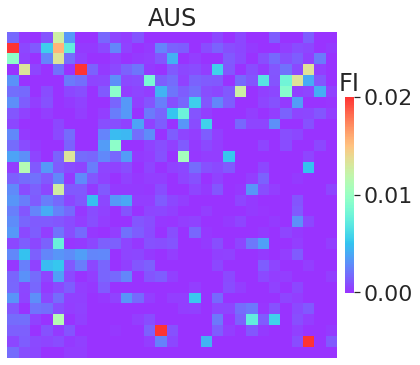

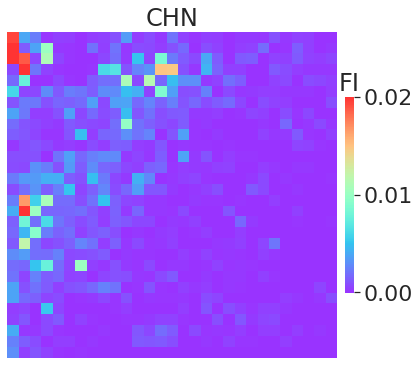

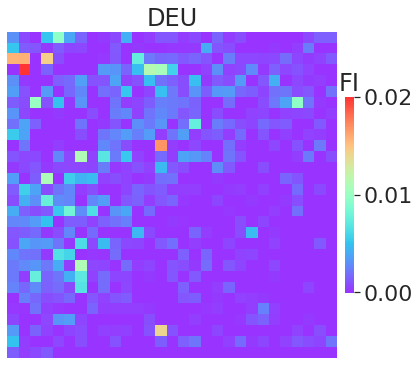

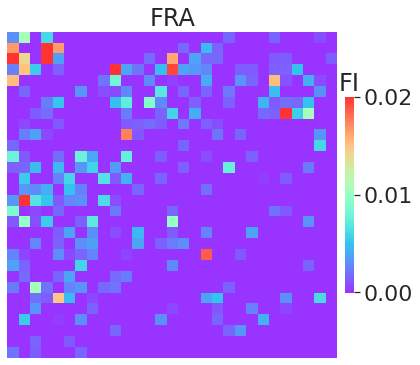

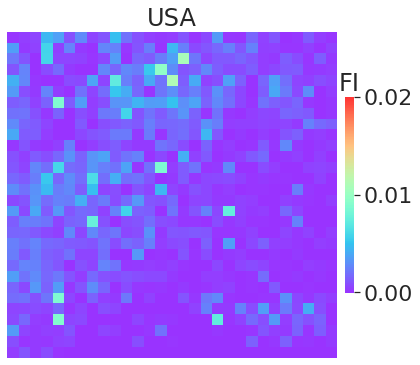

In [23]:
for country in  rfi.columns:

    fig, ax  = plt.subplots(1, 1, figsize=(6.5, 6))

    imp = rfi[country].values
    
    sns.heatmap(imp.reshape(*mp.fmap_shape),  
                cmap = 'rainbow', alpha = 0.8, ax =ax, yticklabels=0, xticklabels=0, 
                vmax=0.02, vmin=-0.00001,  #norm=Normalize(imp.min(),imp.max()),
                cbar_kws = {'fraction':0.07, 'shrink':0.6, 
                            'aspect': 20, 'pad':0.02, #"ticks":[1, 1.01],
                            #'orientation':'horizontal'
                           }
               )

    ax.set_title(country)
    
    cbar = ax.collections[0].colorbar
    
    cbar.ax.set_title('FI')
    cbar.ax.locator_params(nbins=3)
    
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    
    plt.subplots_adjust(wspace = 0.18)
    
    plt.savefig('./fig/RF_%s.pdf' % country, dpi = 400, bbox_inches="tight")

In [24]:
rfi.to_csv('./fig/04_rfi.csv')